In [1]:
import spacy
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("../Data/FRIENDS_SCRIPT_CLEAN.csv")
print(df.columns)

Index(['line_id_global', 'text', 'speaker', 'season', 'episode', 'scene',
       'utterance', 'EPISODE_ID'],
      dtype='object')


In [14]:
nlp = spacy.load("en_core_web_sm")

TEXT_COL = "text"
SPEAKER_COL = "speaker"
SEASON_COL = "season"
LINE_ID_COL = "line_id_global"

In [15]:
records = []

# metadata
texts   = df[TEXT_COL].fillna("").astype(str).tolist()
speakers = df[SPEAKER_COL].fillna("").astype(str).tolist()
seasons  = df[SEASON_COL].tolist()
line_ids = df[LINE_ID_COL].tolist()

for doc, speaker, season, line_id in zip(          # loops over each Doc for each text - Doc is "The processed version of one text."
    nlp.pipe(texts, batch_size=1000, disable=[]),  # processes many texts in a stream, full pipeline: tagger, parser, ner (named entity recognition)
    speakers,
    seasons,
    line_ids
):
    for token in doc:                           # loops over all tokens in that line’s text
        records.append({
            "line_id_global": line_id,
            "season": season,
            "speaker": speaker,
            "token": token.text,
            "lemma": token.lemma_.lower(),      # lemma (changed to lower)
            "pos": token.pos_,                  # the simple UPOS part-of-speech tag
            "tag": token.tag_,                  # the detailed part-of-speech tag
            "is_stop": token.is_stop,           # Is the token part of a stop list - the most common words of the language?
            "is_alpha": token.is_alpha,         # Is the token an alphabetic characters?
        })

tokens_df = pd.DataFrame(records) # converts it to a dataframe
tokens_df.head()

,line_id_global,season,speaker,token,lemma,pos,tag,is_stop,is_alpha
0,1,1,Monica Geller,There,there,PRON,EX,True,True
1,1,1,Monica Geller,'s,be,VERB,VBZ,True,False
2,1,1,Monica Geller,nothing,nothing,PRON,NN,True,True
3,1,1,Monica Geller,to,to,PART,TO,True,True
4,1,1,Monica Geller,tell,tell,VERB,VB,False,True


In [16]:
# takes the lemma column and counts how many times each lemma appears
def get_freq_from_tokens(tokens_df_subset, top_n=None):
    s = tokens_df_subset["lemma"].value_counts()
    if top_n:
        s = s.head(top_n)
    return s                                            # returns Series of word (count) - index = words, values = counts

# expects the Series returned by get_freq_from_tokens, converts them into a dictionary and makes them into a WordCloud object
def plot_wordcloud_from_freq(freq_series, title=None, max_words=200):   # Title - text to show above the plot; max_words – how many words max to show in the cloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=max_words
    ).generate_from_frequencies(freq_series.to_dict())

    plt.figure(figsize=(12, 6))                 # create a new plotting canvas
    plt.imshow(wc, interpolation="bilinear")    # draw the wordcloud image
    plt.axis("off")                             # hide axes, ticks, etc.
    if title:                                   # optional title
        plt.title(title)
    plt.show()                                  # display in the notebook

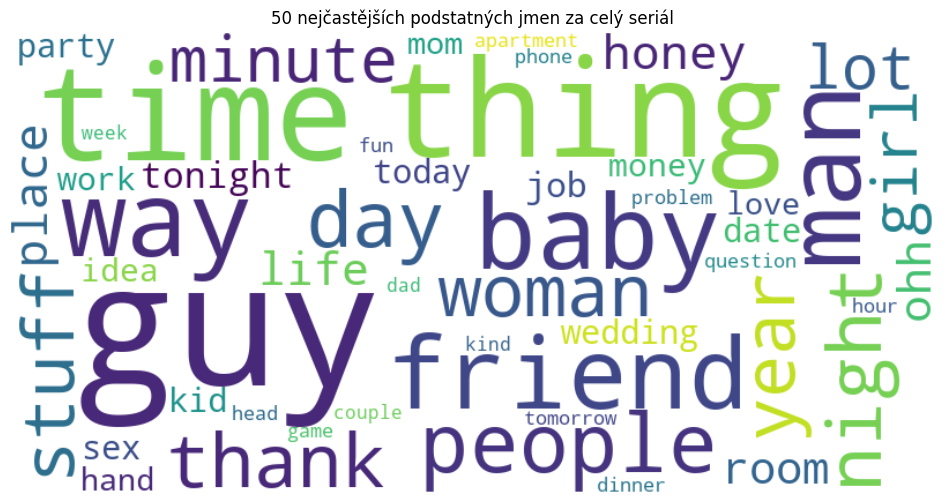

In [ ]:
ALLOWED_POS = {"NOUN"}

show_tokens = tokens_df[
    (tokens_df["speaker"] != "Scene Directions")
    & tokens_df["is_alpha"]
    & ~tokens_df["is_stop"] # without stop words
    & tokens_df["pos"].isin(ALLOWED_POS)
]


freq_all = get_freq_from_tokens(show_tokens, top_n=50)
plot_wordcloud_from_freq(freq_all, title="50 nejčastějších podstatných jmen za celý seriál")

In [ ]:
MAIN_CHARS = [
    "Ross Geller",
    "Rachel Green",
    "Monica Geller",
    "Chandler Bing",
    "Joey Tribbiani",
    "Phoebe Buffay",
]

ALLOWED_POS = {"NOUN"}

main_tokens = tokens_df[
    tokens_df["speaker"].isin(MAIN_CHARS)
    & tokens_df["is_alpha"]
    & ~tokens_df["is_stop"]
    & tokens_df["pos"].isin(ALLOWED_POS)
]

In [ ]:
# counts per speaker and lemma
freq_per_char = (
    main_tokens
    .groupby(["speaker", "lemma"])
    .size()
    .reset_index(name="count")
)

# sort
freq_per_char = freq_per_char.sort_values(
    ["speaker", "count"], ascending=[True, False]
)

# top 20 per speaker
TOP_N = 20
topN = freq_per_char.groupby("speaker").head(TOP_N)

topN.head(30)

,speaker,lemma,count
877,Chandler Bing,guy,286
2014,Chandler Bing,thing,229
2028,Chandler Bing,time,206
1184,Chandler Bing,man,155
2187,Chandler Bing,way,141
1429,Chandler Bing,people,95
2231,Chandler Bing,woman,93
2257,Chandler Bing,year,92
1315,Chandler Bing,night,88
824,Chandler Bing,girl,80


In [ ]:
# how many different characters each lemma appears in
overlap_counts = (
    topN.groupby("lemma")["speaker"]
        .nunique()
        .sort_values(ascending=False)
)

# words that appear in at least 2 characters top 20
overlap_words = overlap_counts[overlap_counts > 1]
overlap_words

lemma
baby       6
thing      6
day        6
girl       6
friend     6
guy        6
stuff      6
people     6
night      6
way        6
time       6
year       5
woman      5
man        5
minute     5
place      4
lot        4
thank      4
life       3
tonight    2
ohh        2
honey      2
job        2
room       2
Name: speaker, dtype: int64

In [68]:
character_specific_topN = topN[~topN["lemma"].isin(overlap_words.index)]

character_specific_topN.head(30)

,speaker,lemma,count
806,Chandler Bing,game,64
3090,Joey Tribbiani,hand,55
2341,Joey Tribbiani,audition,51
6310,Monica Geller,wedding,75
6348,Monica Geller,work,55
7583,Phoebe Buffay,money,48
7134,Phoebe Buffay,fun,45
9043,Rachel Green,date,65
8607,Rachel Green,apartment,60


In [ ]:
overlap_lemmas = set(overlap_words.index)
len(overlap_lemmas), list(overlap_lemmas)[:10]


(24,
 ['girl',
  'lot',
  'honey',
  'minute',
  'ohh',
  'baby',
  'night',
  'friend',
  'thank',
  'thing'])


Top words for Ross Geller (character-specific, no overlaps):
lemma
date        54
kid         53
idea        52
sister      50
sex         46
today       46
mom         45
boy         43
head        41
party       41
dad         40
question    40
fun         39
wife        38
work        37
Name: count, dtype: int64


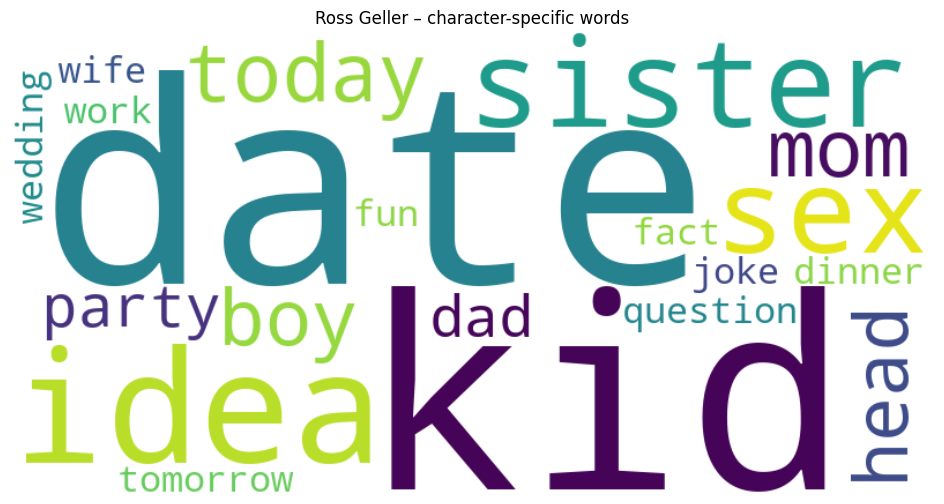


Top words for Rachel Green (character-specific, no overlaps):
lemma
date         65
apartment    60
today        52
phone        51
love         47
party        46
work         44
wedding      43
sex          43
hour         41
idea         40
deal         38
tomorrow     37
hand         36
fun          36
Name: count, dtype: int64


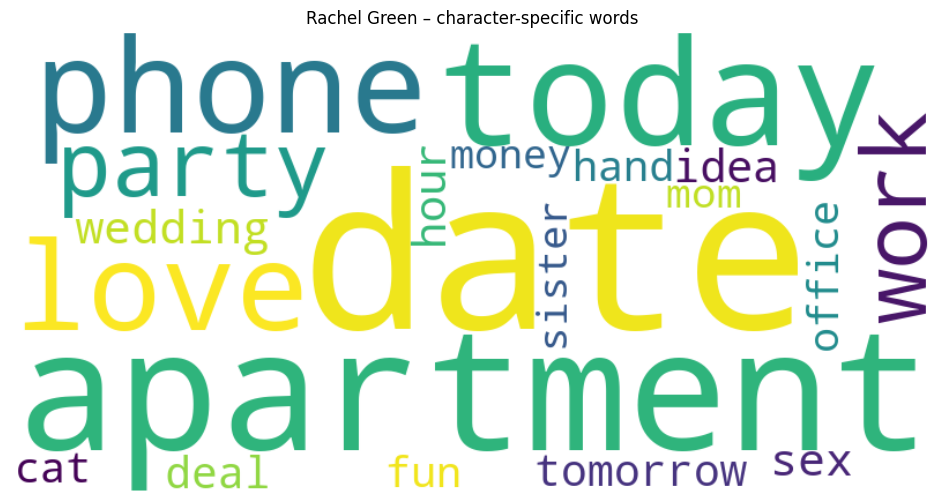


Top words for Monica Geller (character-specific, no overlaps):
lemma
wedding     75
work        55
sex         50
mom         48
party       48
hour        48
dinner      48
game        43
dad         41
head        39
week        38
today       37
money       37
idea        35
tomorrow    33
Name: count, dtype: int64


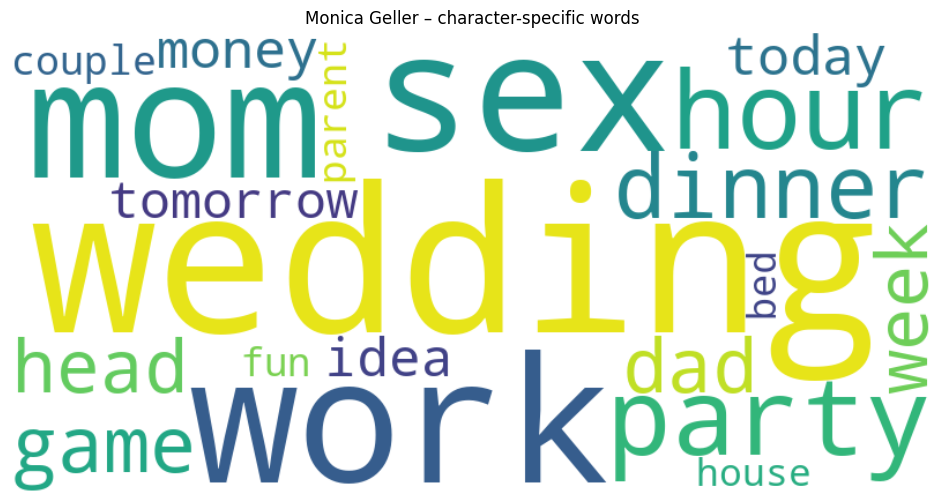


Top words for Chandler Bing (character-specific, no overlaps):
lemma
game        64
money       54
kid         54
sex         52
work        48
wedding     46
phone       45
ring        42
idea        42
party       42
hour        41
joke        39
tomorrow    38
love        37
hand        36
Name: count, dtype: int64


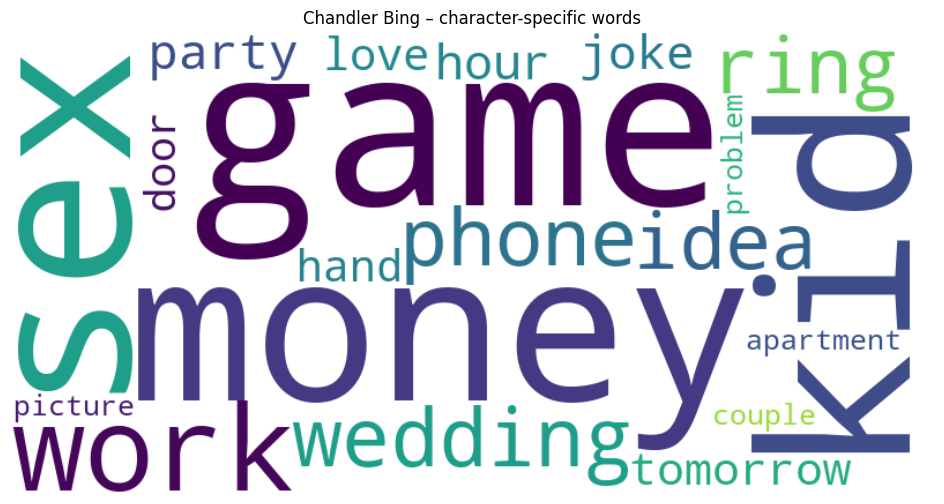


Top words for Joey Tribbiani (character-specific, no overlaps):
lemma
hand        55
audition    51
actor       50
game        47
money       47
movie       47
kid         47
dude        47
sex         46
today       44
problem     44
whoa        42
date        41
hell        40
deal        39
Name: count, dtype: int64


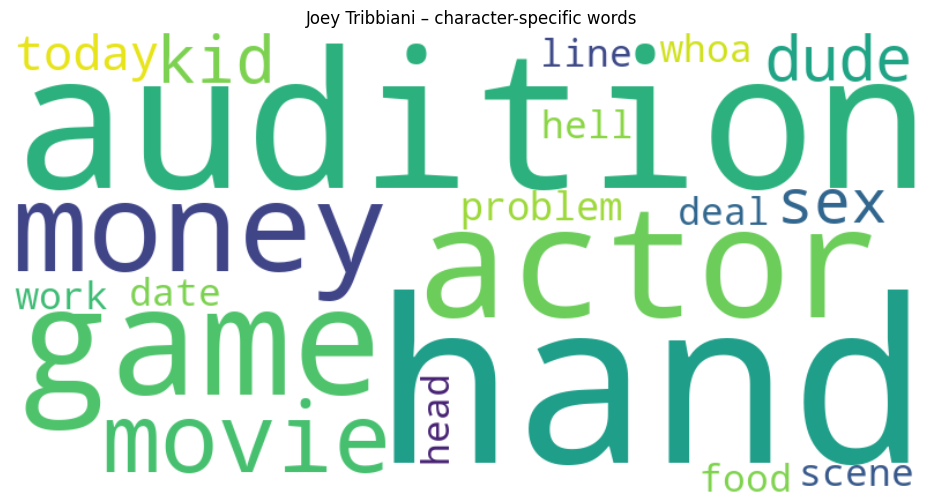


Top words for Phoebe Buffay (character-specific, no overlaps):
lemma
money      48
fun        45
mom        44
wedding    41
massage    41
party      40
love       40
song       38
kid        36
date       35
ass        34
hand       34
head       33
yay        33
today      33
Name: count, dtype: int64


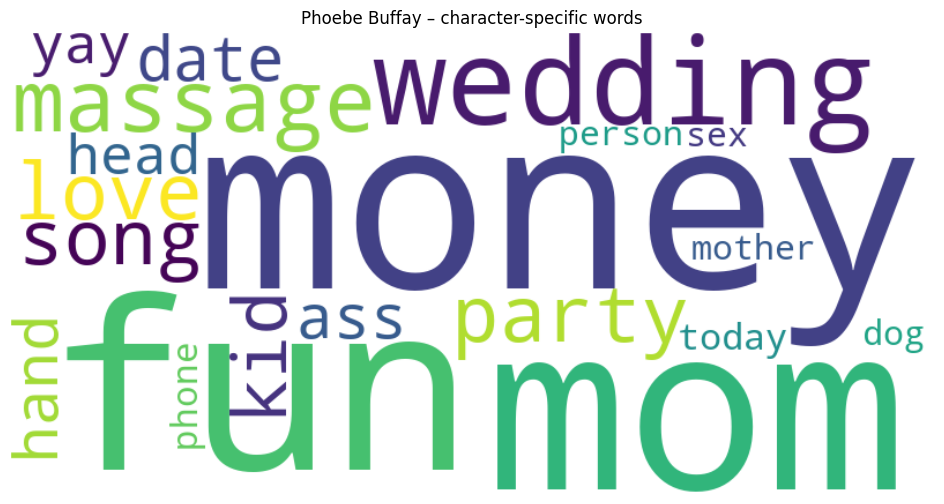

In [64]:
for char in MAIN_CHARS:
    char_tokens = tokens_df[
        (tokens_df["speaker"] == char)
        & tokens_df["is_alpha"]
        & ~tokens_df["is_stop"]
        & tokens_df["pos"].isin(ALLOWED_POS)
        & ~tokens_df["lemma"].isin(overlap_lemmas)
    ]

    freq_char = get_freq_from_tokens(char_tokens, top_n=20)

    print(f"\nTop words for {char} (character-specific, no overlaps):")
    print(freq_char.head(15))

    plot_wordcloud_from_freq(
        freq_char,
        title=f"{char} – character-specific words"
    )

In [ ]:
MAIN_CHARS = [
    "Ross Geller",
    "Rachel Green",
    "Monica Geller",
    "Chandler Bing",
    "Joey Tribbiani",
    "Phoebe Buffay",
]

JUNK_LEMMAS = {"ooh", "god", "umm", "huh", "ohh", "lot"}

NOUN_POS = {"NOUN", "PROPN"}

main_nouns = tokens_df[
    tokens_df["speaker"].isin(MAIN_CHARS)
    & tokens_df["is_alpha"]
    & ~tokens_df["is_stop"]
    & tokens_df["pos"].isin(NOUN_POS)
    & ~tokens_df["lemma"].isin(JUNK_LEMMAS)
]

noun_counts = (
    main_nouns
    .groupby(["speaker", "lemma", "pos"])   # POS column
    .size()
    .reset_index(name="count")
)

# total nouns per speaker
total_nouns_per_speaker = (
    noun_counts.groupby("speaker")["count"].sum()
)

# total nouns per speaker (repeated for all rows of that speaker)
noun_counts["total_nouns_speaker"] = (
    noun_counts.groupby("speaker")["count"].transform("sum")
)

# normalized frequency
noun_counts["rel_freq"] = noun_counts["count"] / noun_counts["total_nouns_speaker"]

TOP_N = 30

noun_counts_sorted = noun_counts.sort_values(
    ["speaker", "count"], ascending=[True, False]
)

top_nouns_per_char = (
    noun_counts_sorted
    .groupby("speaker")
    .head(TOP_N)
    .reset_index(drop=True)
)

top_nouns_per_char.head(40)


,speaker,lemma,pos,count,total_nouns_speaker,rel_freq
0,Chandler Bing,guy,NOUN,286,13432,0.021292
1,Chandler Bing,joey,PROPN,229,13432,0.017049
2,Chandler Bing,thing,NOUN,229,13432,0.017049
3,Chandler Bing,monica,PROPN,208,13432,0.015485
4,Chandler Bing,time,NOUN,206,13432,0.015337
5,Chandler Bing,ross,PROPN,179,13432,0.013326
6,Chandler Bing,man,NOUN,155,13432,0.011540
7,Chandler Bing,way,NOUN,141,13432,0.010497
8,Chandler Bing,people,NOUN,95,13432,0.007073
9,Chandler Bing,woman,NOUN,93,13432,0.006924


In [62]:
top_nouns_per_char.to_csv(
    "FRIENDS_FREQUENT_WORDS.csv",
    index=False
)